In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

import tensorflow as tf

In [2]:
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d

/Users/marvin/projects/BayesFlow/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from tensorflow_probability import distributions as tfd

In [4]:
benchmark_name = 'slcp'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the slcp model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer

In [5]:
SETTINGS_POST = {
    't_args': {
        'dense_args': dict(units=128, activation='tanh'),
        'n_dense': 2,
        'dropout': True,
        'dropout_prob': 0.3
    },
    's_args': {
        'dense_args': dict(units=128, activation='tanh'),
        'n_dense': 2,
        'dropout': True,
        'dropout_prob': 0.3
    }
}

SETTINGS_LIK = {
    't_args': {
        'dense_args': dict(units=128, activation='tanh'),
        'n_dense': 2,
        'dropout': True,
        'dropout_prob': 0.3
    },
    's_args': {
        'dense_args': dict(units=128, activation='tanh'),
        'n_dense': 2,
        'dropout': True,
        'dropout_prob': 0.3
    }
}

latent_dist_p = tfd.MultivariateStudentTLinearOperator(
    df=10, loc=[0.]*5, scale=tf.linalg.LinearOperatorDiag([1.]*5))
latent_dist_l = tfd.MultivariateStudentTLinearOperator(
    df=10, loc=[0.]*8, scale=tf.linalg.LinearOperatorDiag([1.]*8))

amortizer = AmortizedPosteriorLikelihood(
    AmortizedPosterior(
        InvertibleNetwork(num_params=5, num_coupling_layers=10, use_soft_flow=True, coupling_net_settings=SETTINGS_POST),
        latent_dist=latent_dist_p),
    AmortizedLikelihood(
        InvertibleNetwork(num_params=8, num_coupling_layers=4, coupling_net_settings=SETTINGS_LIK),
        latent_dist=latent_dist_l)
)

In [6]:
trainer = Trainer(
    amortizer=amortizer,
    default_lr=5e-4,
    generative_model=benchmark.generative_model,
    configurator=benchmark.configurator,
    checkpoint_path=f'checkpoints/{benchmark_name}',
    memory=False   
)

INFO:root:Loaded loss history from checkpoints/slcp/history_300.pkl.
INFO:root:Networks loaded from checkpoints/slcp/ckpt-300
INFO:root:Performing a consistency check with provided components...
2023-02-16 13:06:53.018819: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
INFO:root:Done.


# Training

Uncomment for training.

In [7]:
# EPOCHS = 300
# SIMULATION_BUDGET = 10000
# BATCH_SIZE = 128
# N_VAL = 300

# train_data = trainer.generative_model(SIMULATION_BUDGET)

# h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

# Validation

## Loss Trajectories

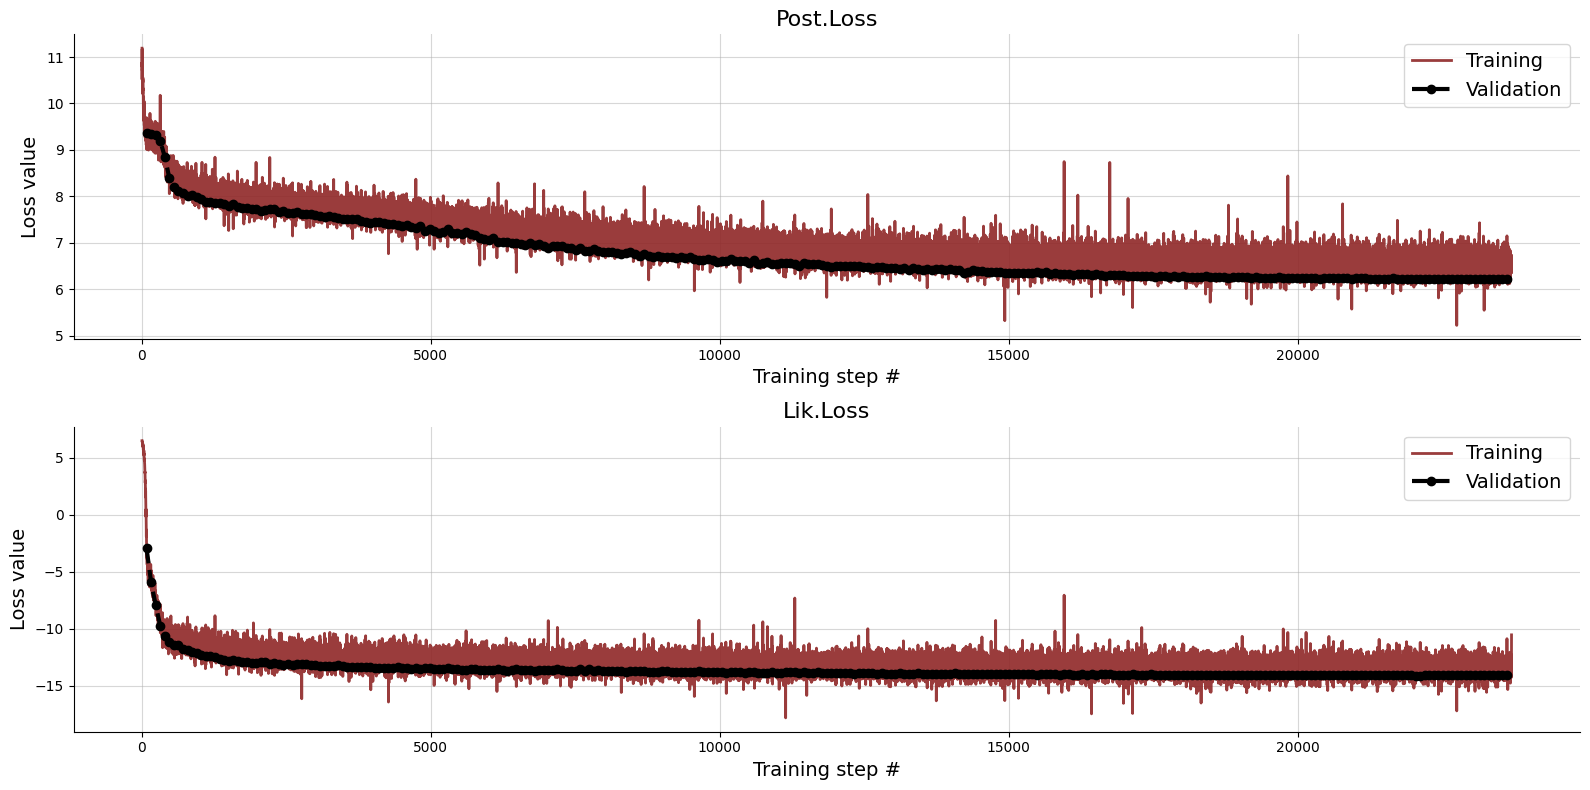

In [8]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

## Test (Held-Out) Data

In [9]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

### Latent Inspection

In [10]:
out_p, out_l = amortizer(test_dict)
z_p = out_p[0]
z_l = out_l[0]

#### Posterior

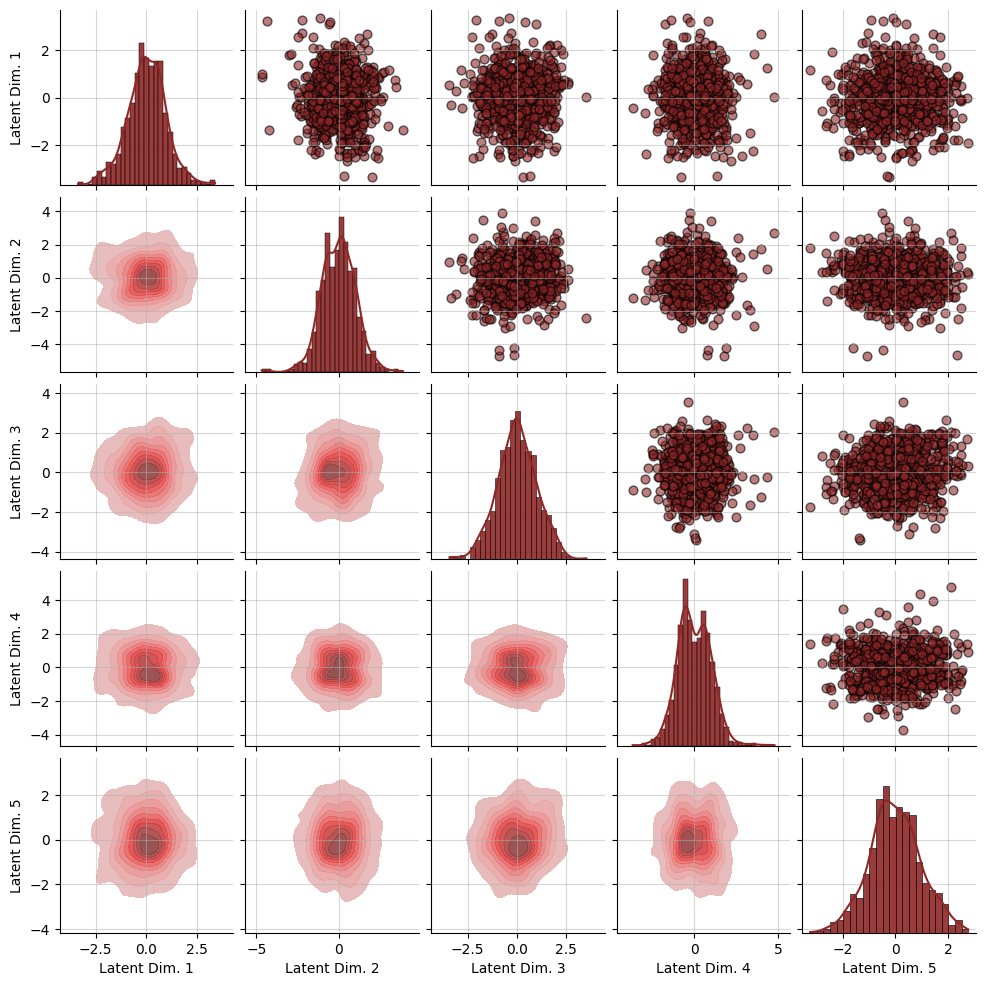

In [11]:
f = plot_latent_space_2d(z_p, height=2)

#### Likelihood

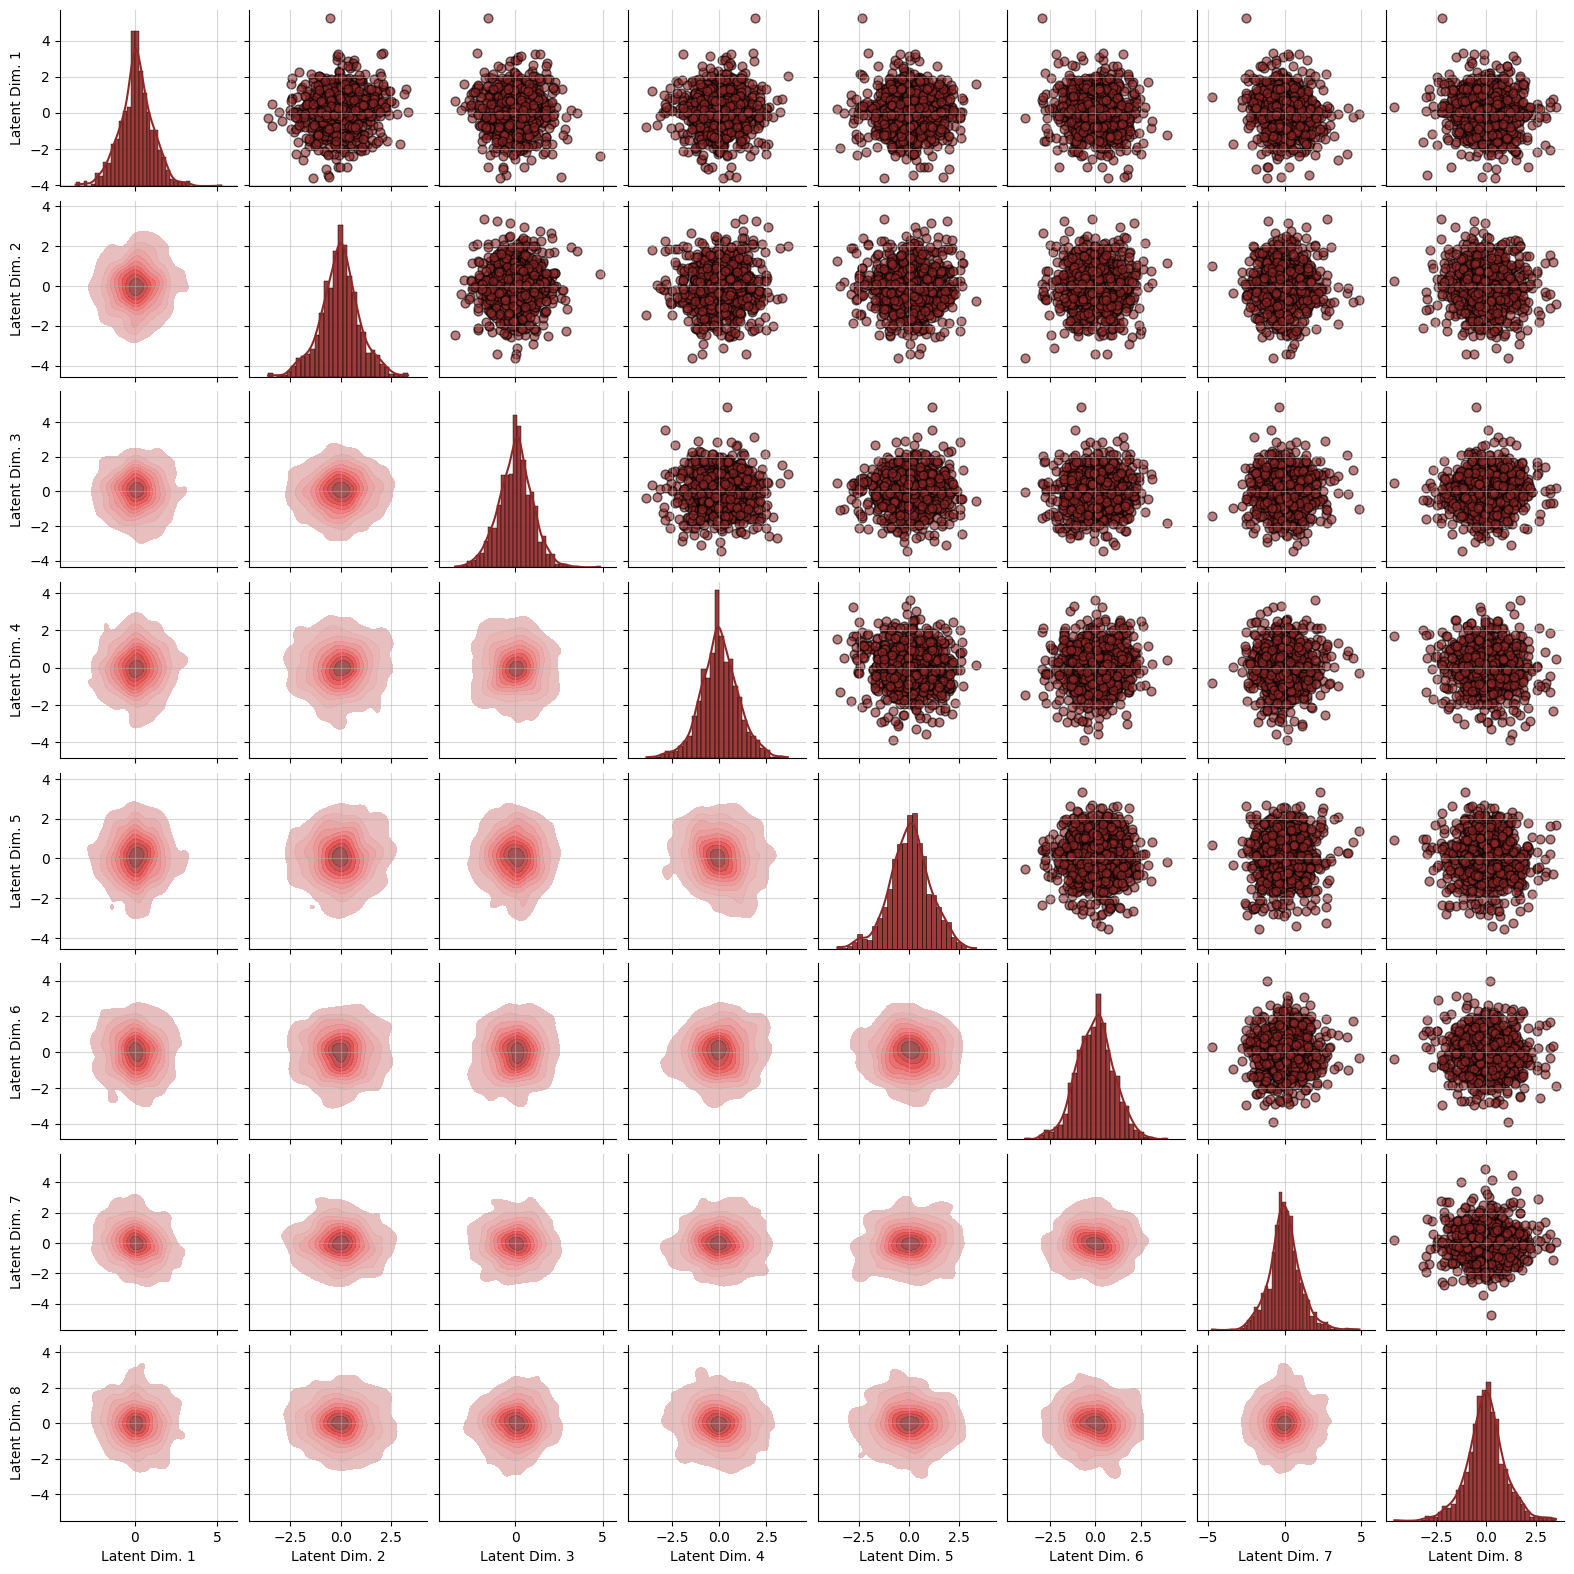

In [12]:
f = plot_latent_space_2d(z_l, height=2)

In [13]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'direct_conditions': x_sim_s}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

### Calibration

#### ECDF Difference (Stacked)

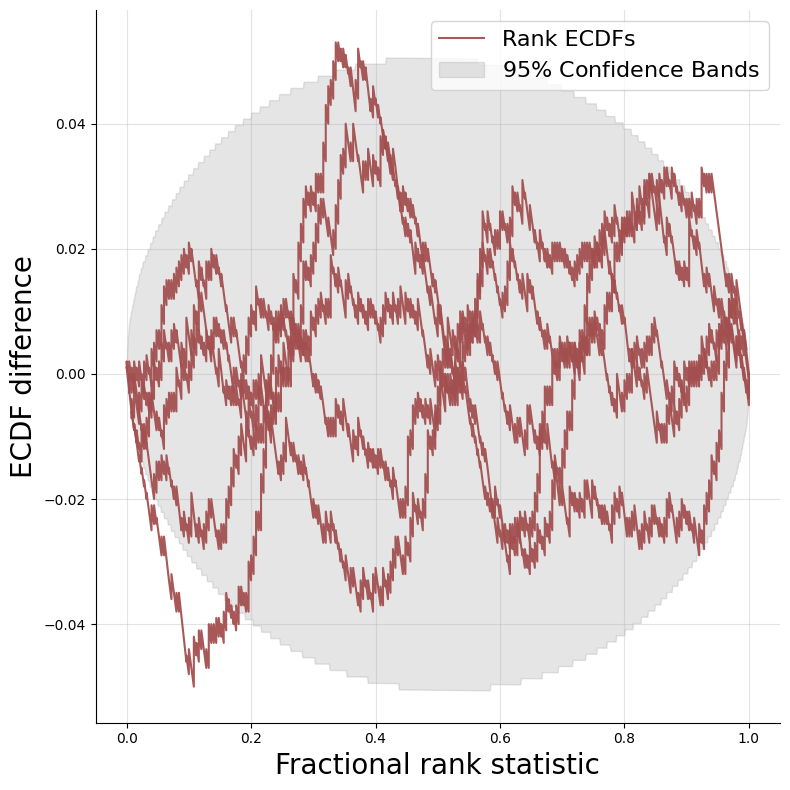

In [14]:
f = plot_sbc_ecdf(post_samples, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True,
                  difference=True, fig_size=(8, 8), label_fontsize=20, legend_fontsize=16)
f.savefig(f'figures/calibration/{benchmark_name}.pdf')

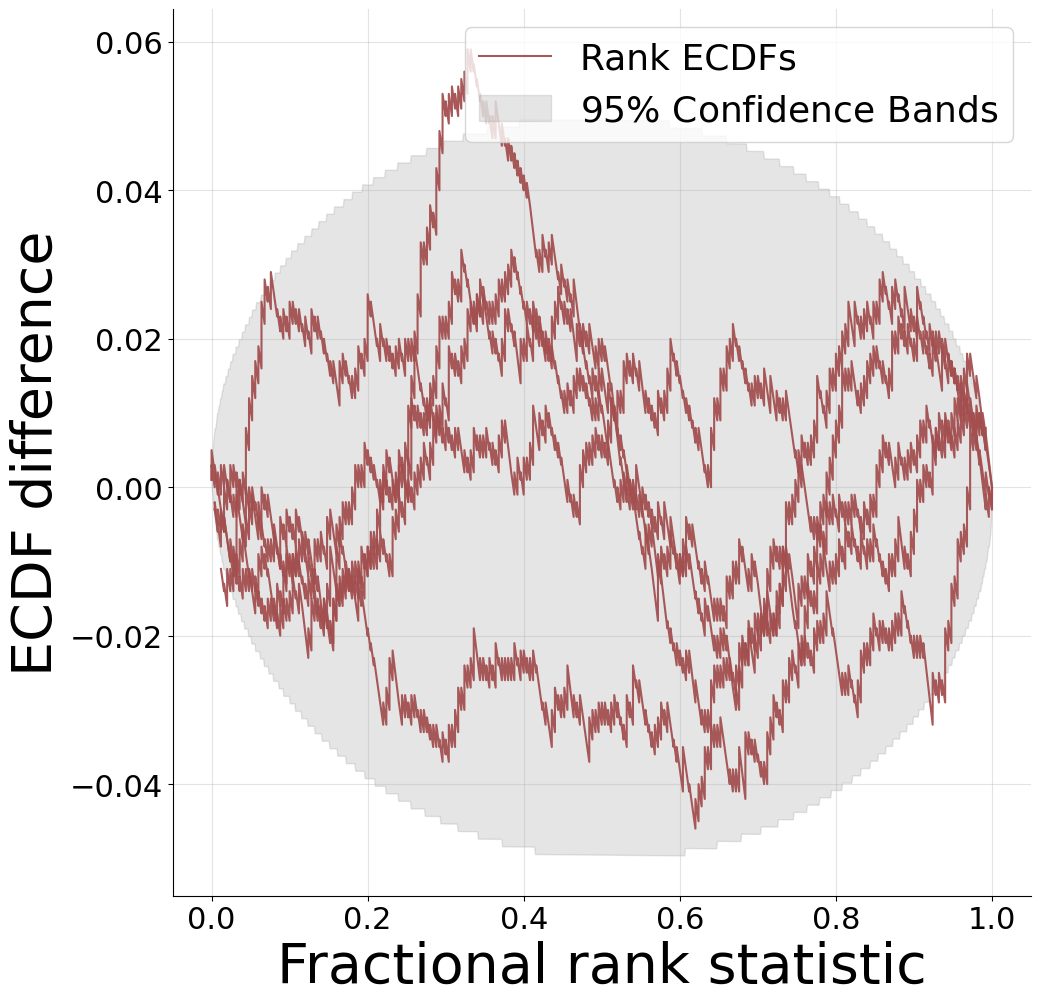

In [15]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True,
                  difference=True, fig_size=(10, 10), label_fontsize=40, legend_fontsize=26)
_ = plt.xticks(fontsize=22)
_ = plt.yticks(fontsize=22)
f.savefig(f'figures/calibration/{benchmark_name}_diff.pdf', dpi=300, bbox_inches='tight')

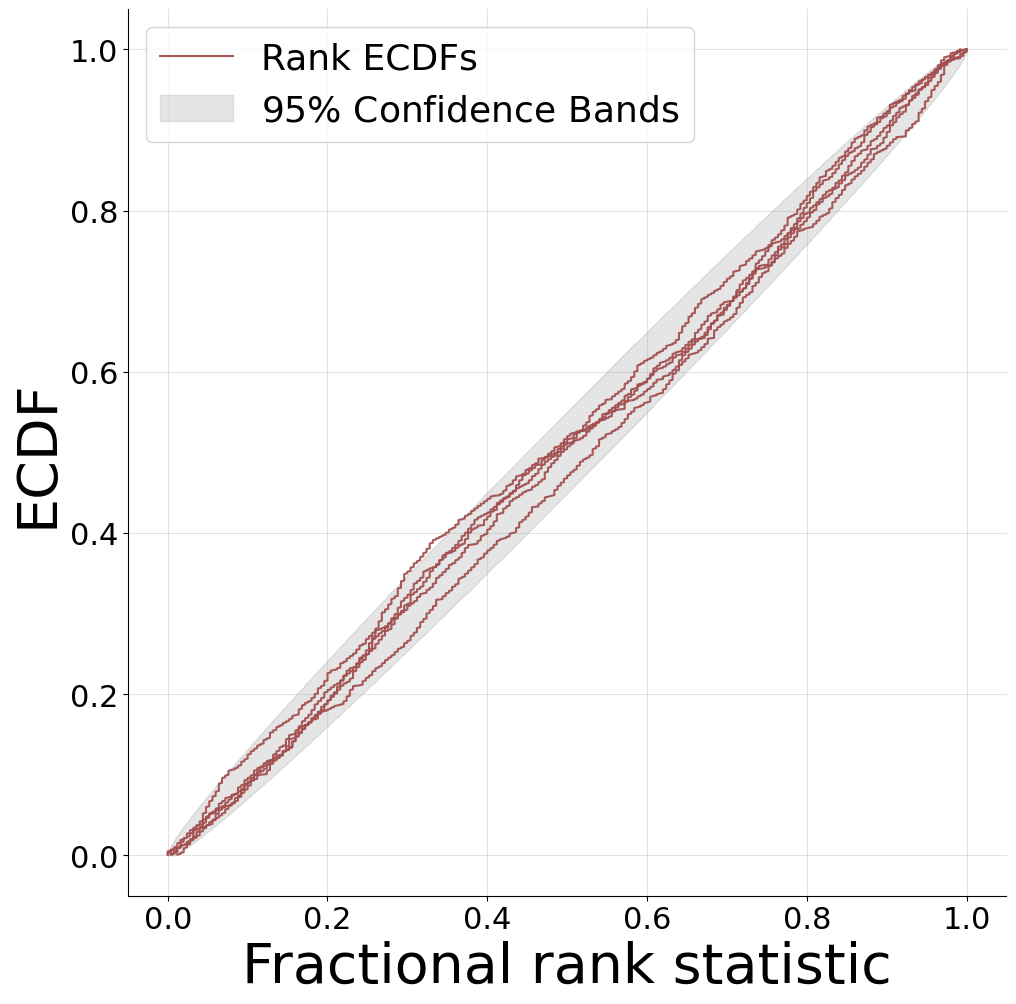

In [16]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True, fig_size=(10, 10), label_fontsize=40, legend_fontsize=26)
_ = plt.xticks(fontsize=22)
_ = plt.yticks(fontsize=22)
f.savefig(f'figures/calibration/{benchmark_name}.pdf', dpi=300, bbox_inches='tight')

#### Individual ECDF Plots

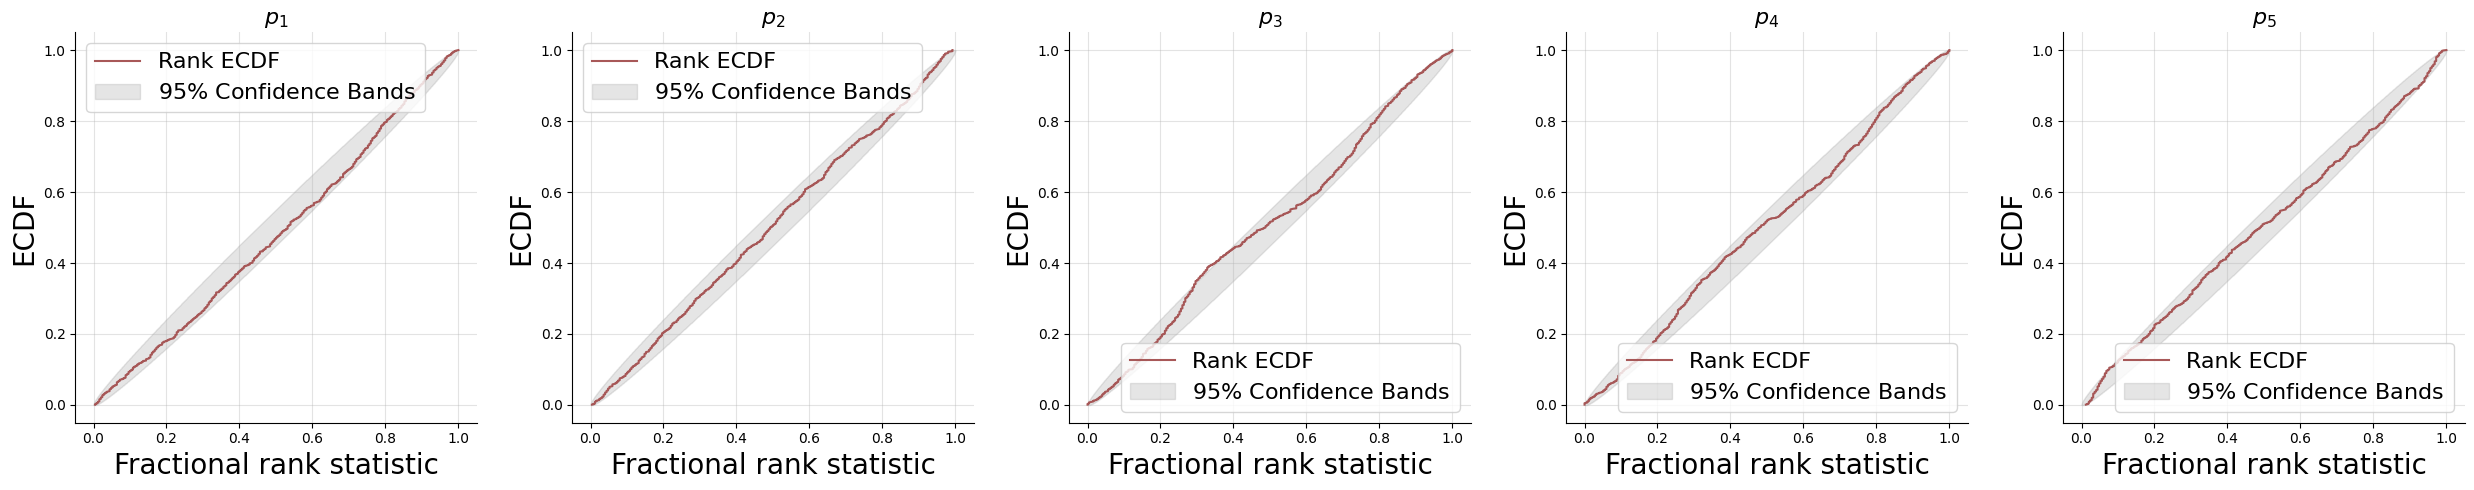

In [17]:
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), 
                  label_fontsize=20, legend_fontsize=16)

#### Recovery
Observe the hints for bimodality!

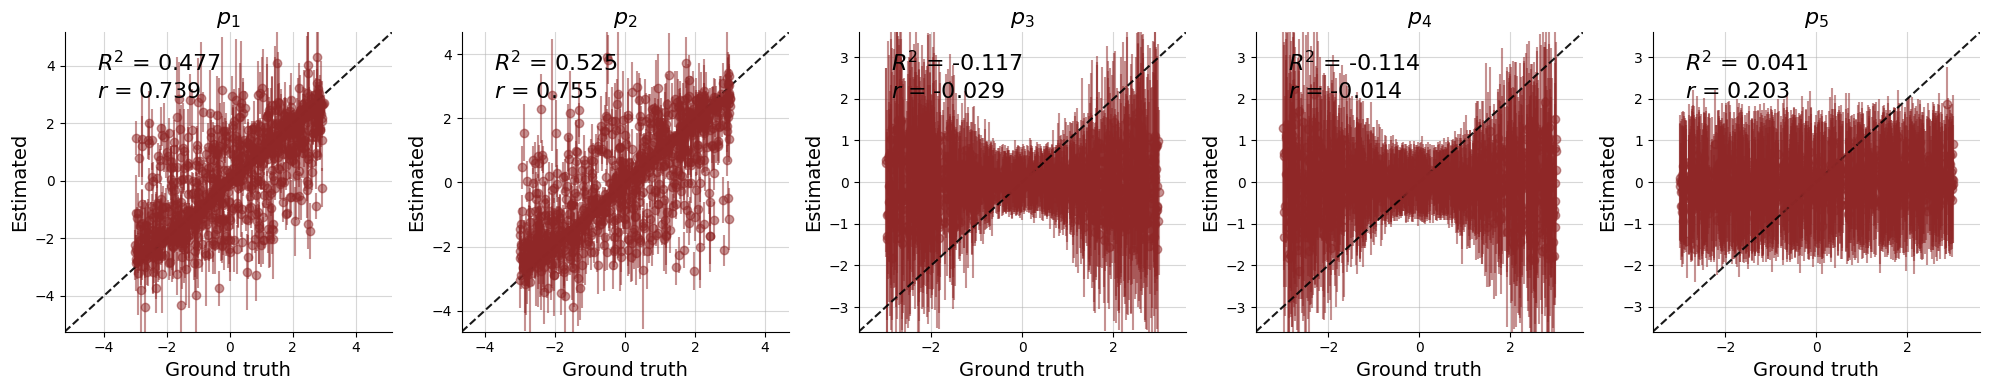

In [18]:
f = plot_recovery(post_samples, prior_samples)

### Some full posteriors

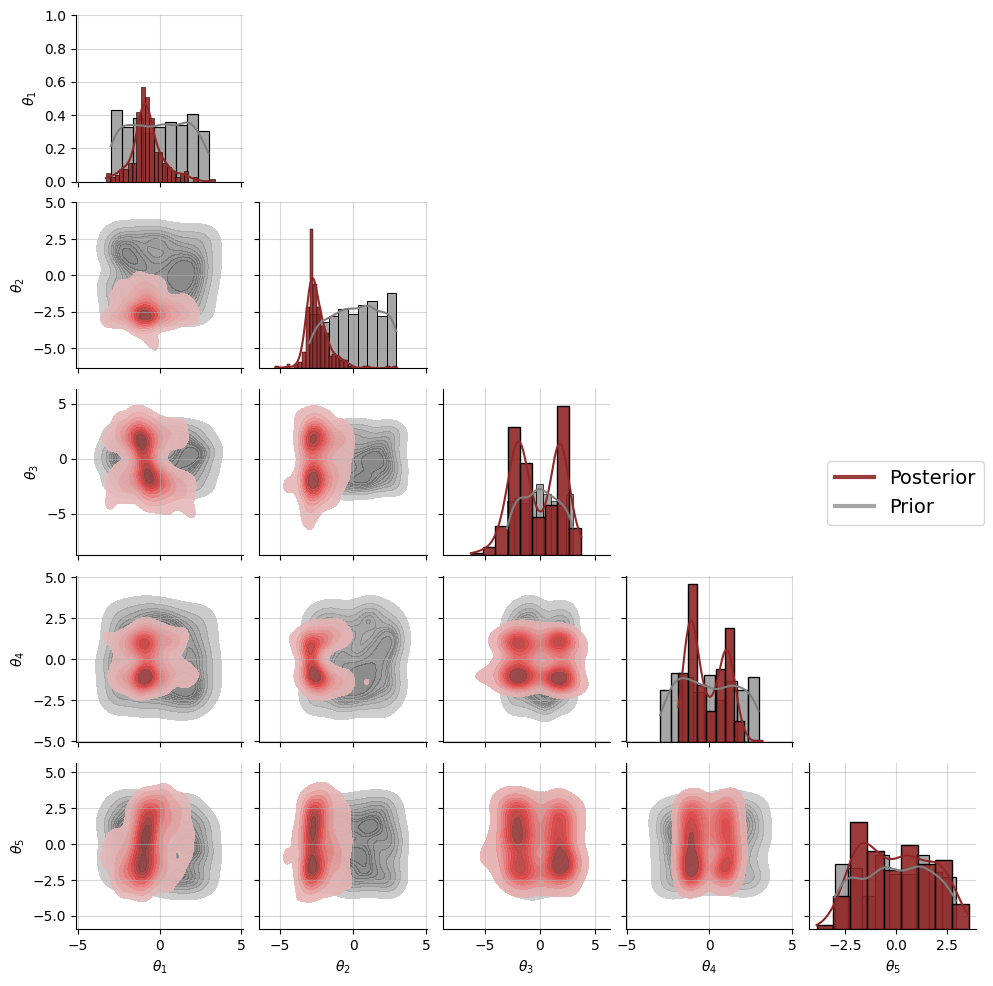

In [19]:
f = plot_posterior_2d(post_samples[0], prior=benchmark.generative_model.prior, height=2)

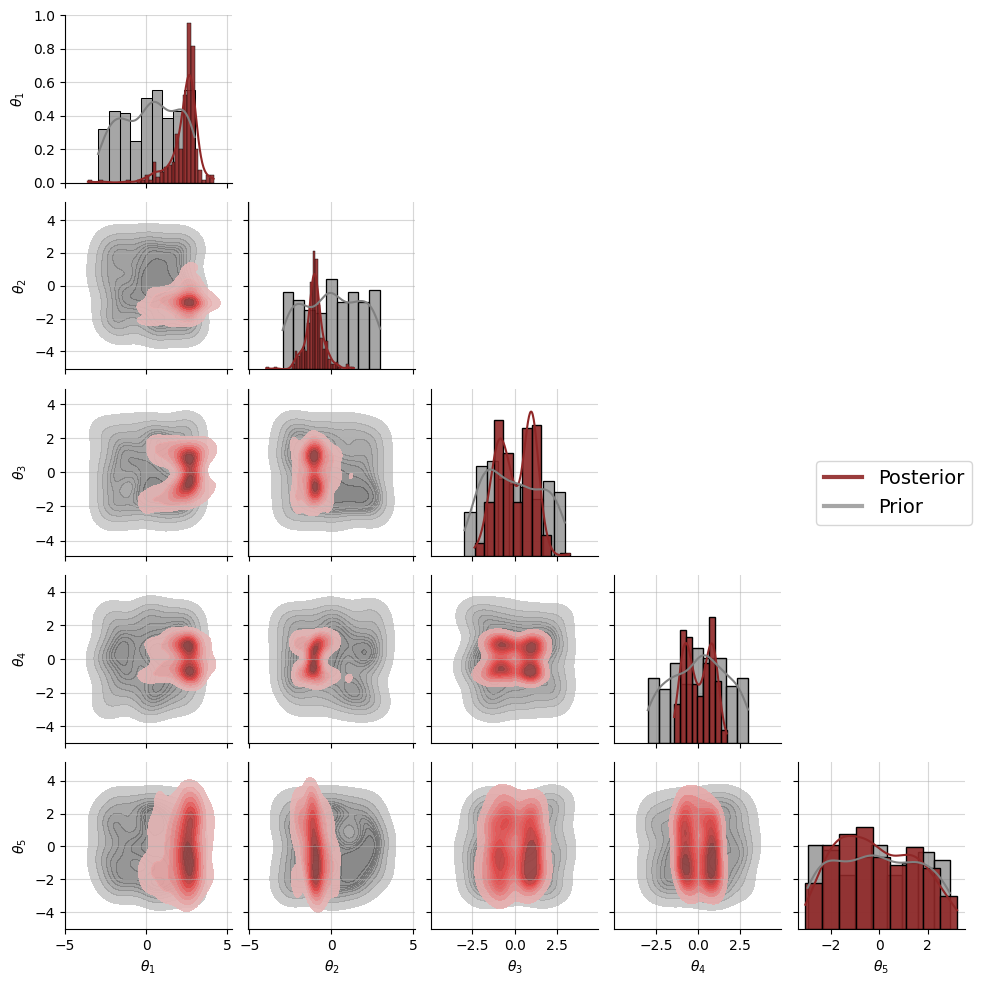

In [20]:
f = plot_posterior_2d(post_samples[1], prior=benchmark.generative_model.prior, height=2)

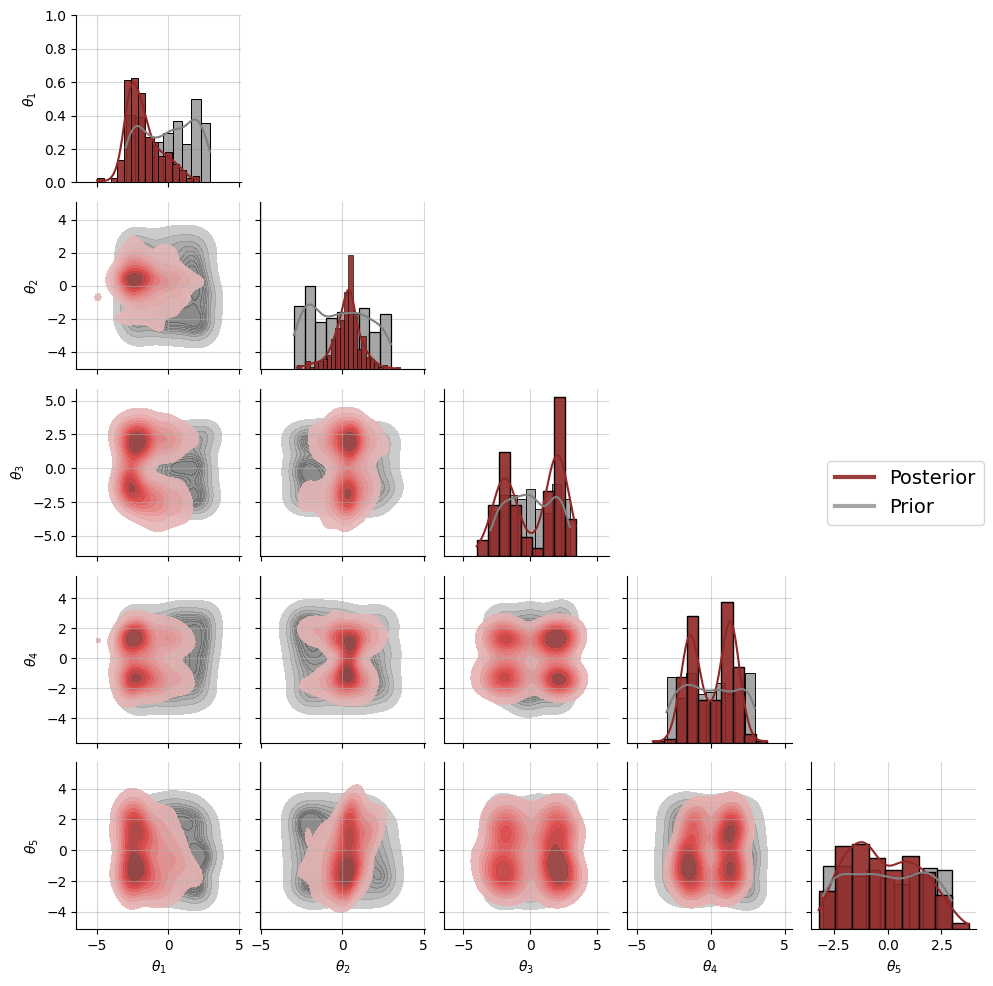

In [21]:
f = plot_posterior_2d(post_samples[2], prior=benchmark.generative_model.prior, height=2)

# Appendix Plots

In [22]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

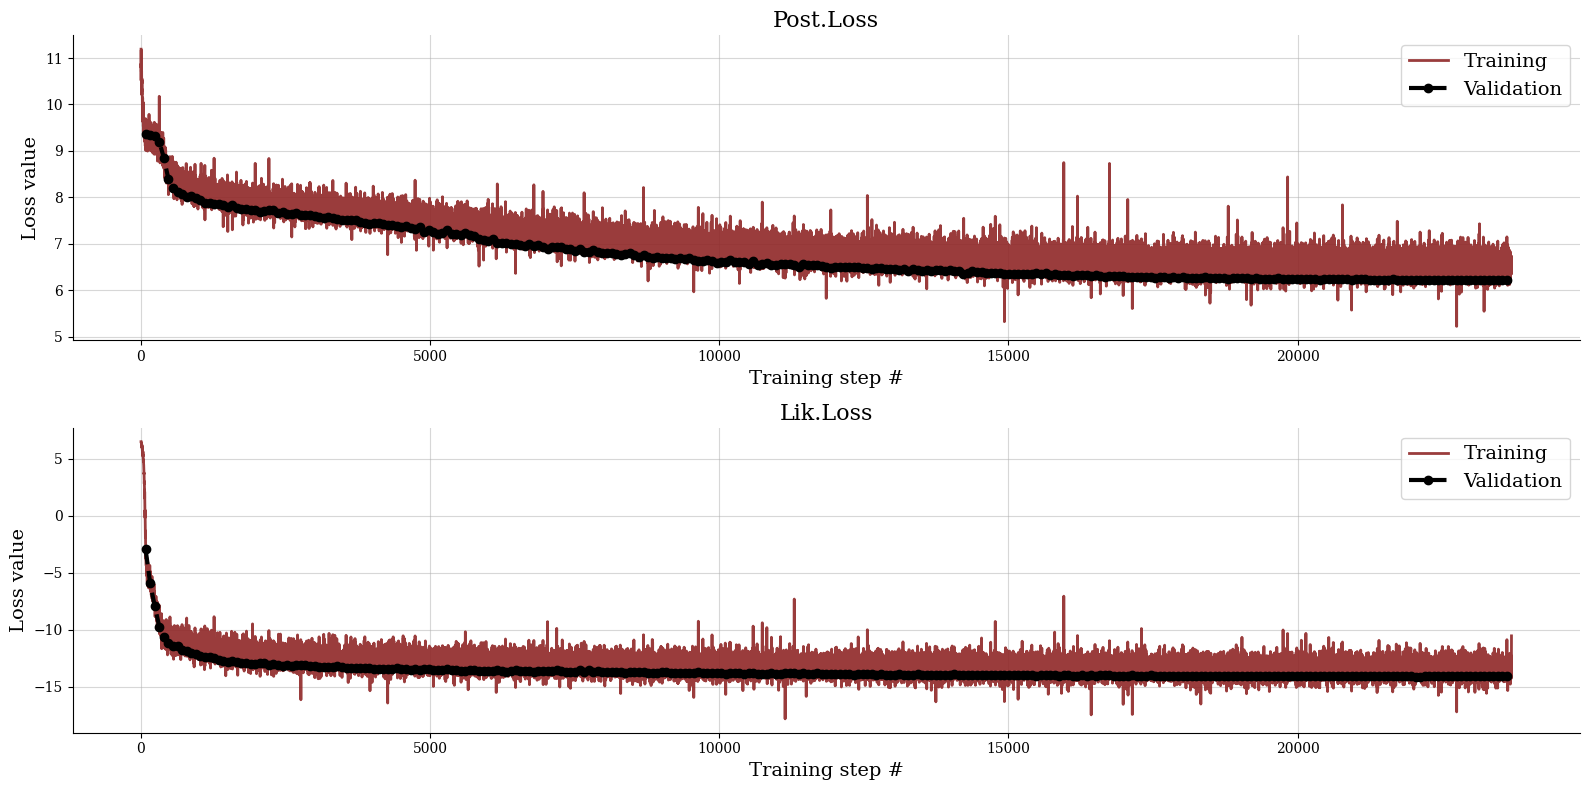

In [23]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

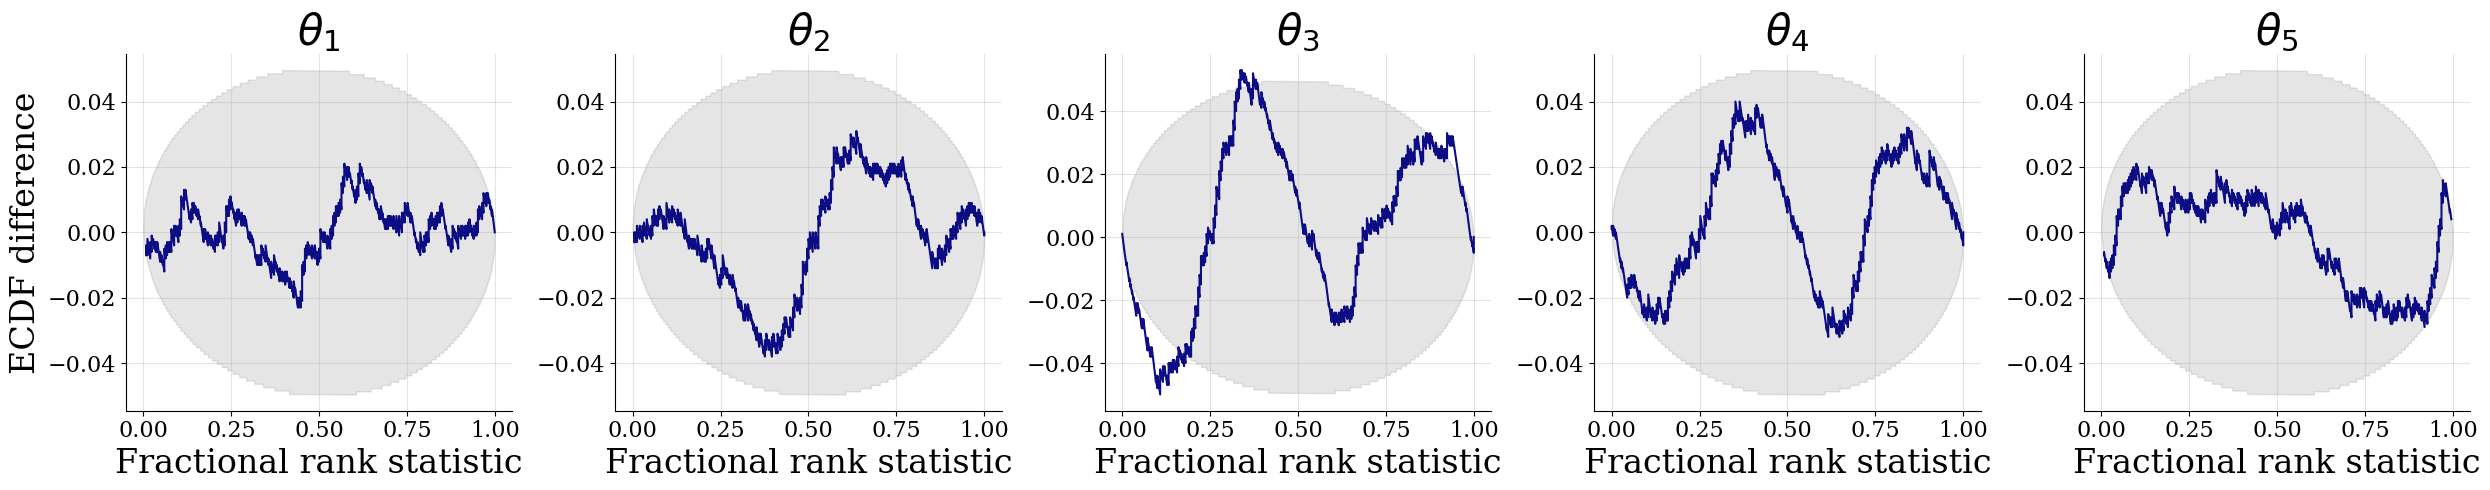

In [24]:
f = plot_sbc_ecdf_appendix(post_samples, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), 
                           param_names = benchmark.benchmark_info['parameter_names'],
                           label_fontsize=24, legend_fontsize=24, difference=True, rank_ecdf_color = '#000080' )
plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi = 300, bbox_inches = "tight")

### Joint Calibration

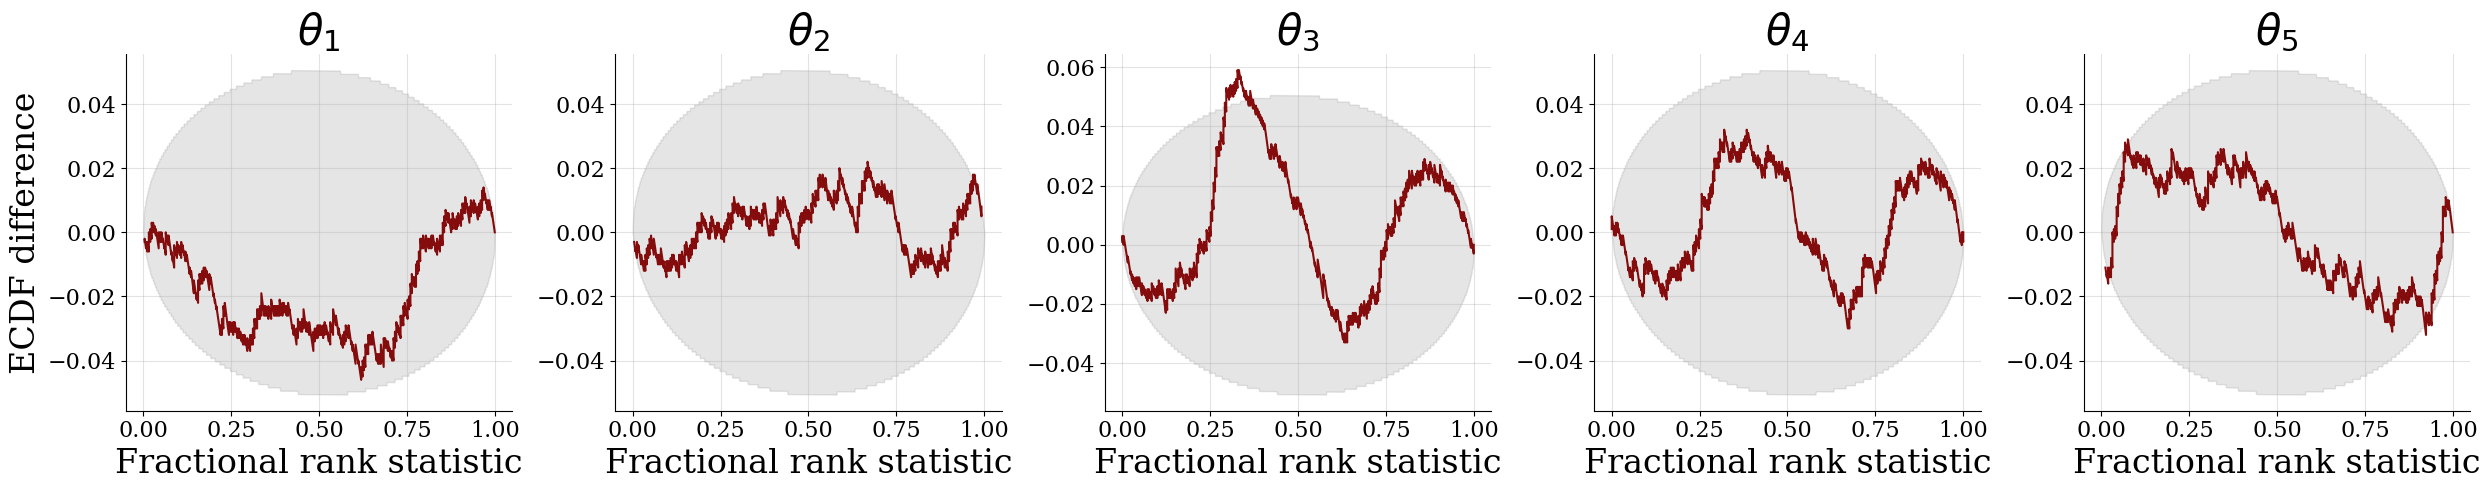

In [25]:
f = plot_sbc_ecdf_appendix(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), 
                           param_names = benchmark.benchmark_info['parameter_names'],
                           label_fontsize=24, legend_fontsize=24, difference=True, rank_ecdf_color = '#800000')
plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi = 300, bbox_inches = "tight")